In [1]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

from PIL import Image
from sklearn import preprocessing
import sys
from pathlib import Path
from PIL import Image
import torch
import numpy as np
from molmo_utils import load_model, do_inference, get_coordinates, calculate_probability_of_coordinates
from utils import extract_all, plot_scatter, calculate_normalized_euclidian_distance, visualize_points_on_image, calculate_spread, calculate_all_clusters, show_all_clusters, calculate_roc_curve, plot_roc_curve, find_best_threshold

2025-03-15 21:37:23.729117: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-15 21:37:24.553468: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-15 21:37:24.553506: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-15 21:37:24.553538: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 21:37:24.955695: I tensorflow/core/platform/cpu_feature_g

In [2]:
model_name = 'allenai/Molmo-7B-D-0924'
model, processor = load_model(model_name)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
def run_experiment_different_prompts(path_to_experiments, prompt_starts, runs_per_task, temperature, epsilon, min_samples):
    tasks, images, ground_truths, objects = extract_all(path_to_experiments)
    prompt_end = " Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the relevant object. Dont output anything else."
    softmax_fn = torch.nn.Softmax(dim=-1)
    labels = []

    coordinates = [[],[]]

    distances = [[],[]]
    
    spreads = [[],[]]

    diameters = [[],[]]

    majority_size_rates = [[],[]]


    probs = [[],[]]
    
    for i in range(len(tasks)):
        prompts = []
        task = tasks[i]
        labels.append(task)
        ground_truth = ground_truths[i]

        objects_of_task = objects[i]
        prompts_what = []
        for prompt_start in prompt_starts:
            prompt = prompt_start + task + "For that you have to point to the object in the picture that has to be moved." + prompt_end
            prompts_what.append(prompt)

        prompts.append(prompts_what)


        print(f"{task}")
        with Image.open(images[i]) as image:
            image_width = image.width
            image_height = image.height
    
            if (len(ground_truth) == 2):
                prompts_where = []
                for prompt_start in prompt_starts:
                    prompt = prompt_start + task + "For that you have to point to the place in the picture where the object has to be moved to." +  prompt_end
                    prompts_where.append(prompt)
                labels.append(task)
                prompts.append(prompts_where)
    
            for k in range(len(prompts)):
                task_coordinates = []
                task_distances = []
                probabilities = []

                for prompt in prompts[k]:
                    for j in range(runs_per_task):
                        output_text, output, inputs = do_inference(image, prompt, model, processor, temperature)                    
                        coords = get_coordinates(output_text, image_width, image_height)
                        if(coords[0] < 0 or coords[0] < 0):
                            continue
                        
                        norm_dist = calculate_normalized_euclidian_distance(coords, ground_truth[k], image_width, image_height)
                        task_coordinates.append(coords)
                        task_distances.append(norm_dist)
                        probabilities.append(calculate_probability_of_coordinates(output, inputs, processor))
                    coordinates[k].append(task_coordinates)

                probs[k].append(np.mean(probabilities))
                distances[k].append(np.mean(task_distances))
                spreads[k].append(calculate_spread(task_coordinates, image_width, image_height))
                            

    return labels, distances[0] + distances[1], spreads[0] + spreads[1], probs[0] + probs[1]


In [3]:
def run_spread_and_prob_experiment_cluster(path_to_experiments, prompt_starts, runs_per_task, temperature, epsilon, min_samples):
    tasks, images, ground_truths, objects = extract_all(path_to_experiments)
    prompt_end = " Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the relevant object. Dont output anything else."
    softmax_fn = torch.nn.Softmax(dim=-1)
    labels = []

    coordinates = [[],[]]

    distances = [[],[]]
    
    spreads = [[],[]]

    diameters = [[],[]]

    majority_size_rates = [[],[]]


    probs = [[],[]]
    
    for i in range(len(tasks)):
        prompts = []
        task = tasks[i]
        labels.append(task)
        ground_truth = ground_truths[i]

        objects_of_task = objects[i]
        prompts_what = []
        for prompt_start in prompt_starts:
            prompt = prompt_start + task + ". For that you have to point to the object in the picture that has to be moved." + prompt_end
            prompts_what.append(prompt)

        prompts.append(prompts_what)


        print(f"{task}")
        with Image.open(images[i]) as image:
            image_width = image.width
            image_height = image.height
    
            if (len(ground_truth) == 2):
                prompts_where = []
                for prompt_start in prompt_starts:
                    prompt = prompt_start + task + ". For that you have to point to the place in the picture where the object has to be moved to." +  prompt_end
                    prompts_where.append(prompt)
                labels.append(task)
                prompts.append(prompts_where)
    
            for k in range(len(prompts)):
                task_coordinates = []
                task_distances = []
                probabilities = []

                for prompt in prompts[k]:
                    for j in range(runs_per_task):
                        output_text, output, inputs = do_inference(image, prompt, model, processor, temperature)                    
                        coords = get_coordinates(output_text, image_width, image_height)
                        if(coords[0] < 0 or coords[0] < 0):
                            continue
                        
                        norm_dist = calculate_normalized_euclidian_distance(coords, ground_truth[k], image_width, image_height)
                        task_coordinates.append(coords)
                        task_distances.append(norm_dist)
                        probabilities.append(calculate_probability_of_coordinates(output, inputs, processor))
                    coordinates[k].append(task_coordinates)

                n_clusters, index_majority_cluster, cluster_points, noisy_points, centroids, diameters_of_clusters = calculate_all_clusters(task_coordinates, epsilon=epsilon, min_samples=min_samples)
                if (n_clusters != 0):
                    centroid_distance = calculate_normalized_euclidian_distance(centroids[index_majority_cluster], ground_truth[k], image_width, image_height)
                    probs[k].append(np.mean(probabilities))
                    distances[k].append(centroid_distance)
                    spreads[k].append(calculate_spread(task_coordinates, image_width, image_height))
                    majority_size_rates[k].append(len(cluster_points[index_majority_cluster]) / len(task_coordinates))
                           

    return labels, distances[0] + distances[1], spreads[0] + spreads[1], probs[0] + probs[1], majority_size_rates[0] + majority_size_rates[1]

In [21]:
experiment_path = "../data/certain_experiments"
num_runs = 6
temperature = 1

epsilon = 20
min_samples = 3

prompt_starts = [
    "You are the robot in the picture. Your mission it to guide and support the user in its task to: ",
    "Your mission it to guide and support the user in its task to: ",
    "You are the robot in the picture. You have to: ",
    "You are the robot. Your mission is to: ",
    "You are the robot in the picture. Your task is to: "
    ]

#prompt_starts = ["You are the robot in the picture. Your mission it to guide and support the user in its task to: ", "You are the robot in the picture. Your mission it to guide and support the user in its task to: "]
#prompt_ends = [, "  Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the place where the object has to be moved to. Dont output anything else."]

labels, distances, spreads, probs = run_experiment_different_prompts(experiment_path, prompt_starts, num_runs, temperature, epsilon, min_samples)

import numpy as np

np.savez(
    'results/molmo-temp1-5prompts-6runs-certain.npz', 
    labels=labels,
    distances=distances, 
    spreads=spreads,
    probs=probs,
)

pull the oven tray
take cucumber out of cup
move the fruit from the left stove to the sink
open low fridge
open the drawer
Move the can from the top left of the burner to the bottom left of the burner
Place the pot to the right of the blue fork.
move the pot from the right to the left stove
put potato in pot or pan
take cucumber out of cup
move the banana from the left stove to the sink
pick up the toast and put it to the sink
close the microwave
push the toaster lever
take the broccoli and put it between the two right burners
move the pot from the left to the right stove


In [4]:
from matplotlib import pyplot as plt

def plot_scatter_report(labels, list_of_x, list_of_y, filename, title="Scatterplot", x_label="Distance to Groundtruth", y_label="Probabilities"):
    for label, x, y in zip(labels, list_of_x, list_of_y):
        plt.scatter(x, y, marker='o', label=label)
    
    # Adding labels
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(loc="lower right")
    
    # Show the plot
    plt.savefig(filename)
    plt.show()
    plt.close()

def plot_roc_curve_report(fpr, tpr, roc_auc, filename, title = "Receiver Operating Characteristic (ROC) Curve for Distance-Based Classification"):
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color="grey", linestyle="--")  # Random classifier line
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

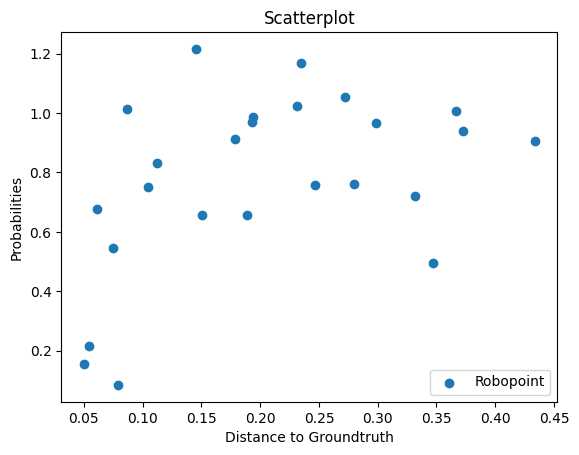

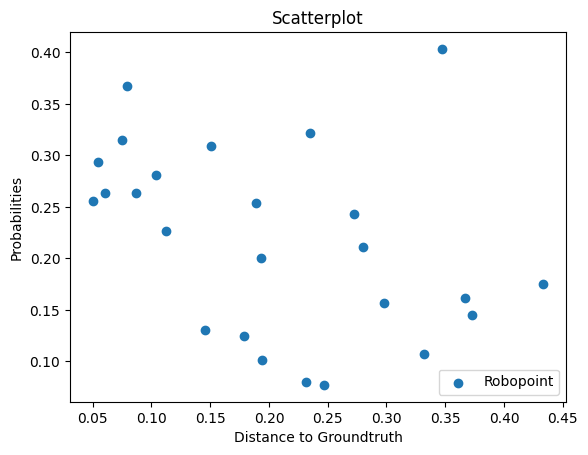

In [25]:
import itertools

data_filename = 'results/molmo-temp1-5prompts-6runs-certain.npz'
plot_filename = 'results/robopoint-temp06-5prompts-6runs-certain.png'

loaded = np.load(data_filename)
distances_robopoint = loaded['distances']
spreads_robopoint = loaded['spreads']
probs_robopoint = loaded['probs']

plot_scatter_report(["Robopoint"], [distances_robopoint], [spreads_robopoint], plot_filename)
plot_scatter_report(["Robopoint"], [distances_robopoint], [probs_robopoint], plot_filename)

In [5]:
experiment_path = "../data/certain_experiments"
num_runs = 6
temperature = 0.8

epsilon = 20
min_samples = 3

prompt_starts = [
    "You are the robot in the picture. Your mission it to guide and support the user in its task to: ",
    "Your mission it to guide and support the user in its task to: ",
    "You are the robot in the picture. You have to: ",
    "You are the robot. Your mission is to: ",
    "You are the robot in the picture. Your task is to: "
    ]

#prompt_starts = ["You are the robot in the picture. Your mission it to guide and support the user in its task to: ", "You are the robot in the picture. Your mission it to guide and support the user in its task to: "]
#prompt_ends = [, "  Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the place where the object has to be moved to. Dont output anything else."]

labels, distances, spreads, probs, majority_size_rates = run_spread_and_prob_experiment_cluster(experiment_path, prompt_starts, num_runs, temperature, epsilon, min_samples)

import numpy as np

np.savez(
    'results/molmo-temp08-5prompts-6runs-certain-cluster.npz', 
    labels=labels,
    distances=distances, 
    spreads=spreads,
    probs=probs,
    majority_size_rates=majority_size_rates
)

pull the oven tray
take cucumber out of cup
move the fruit from the left stove to the sink
open low fridge
open the drawer
Move the can from the top left of the burner to the bottom left of the burner
Place the pot to the right of the blue fork.
move the pot from the right to the left stove
put potato in pot or pan
take cucumber out of cup
move the banana from the left stove to the sink
pick up the toast and put it to the sink
close the microwave
push the toaster lever
take the broccoli and put it between the two right burners
move the pot from the left to the right stove


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


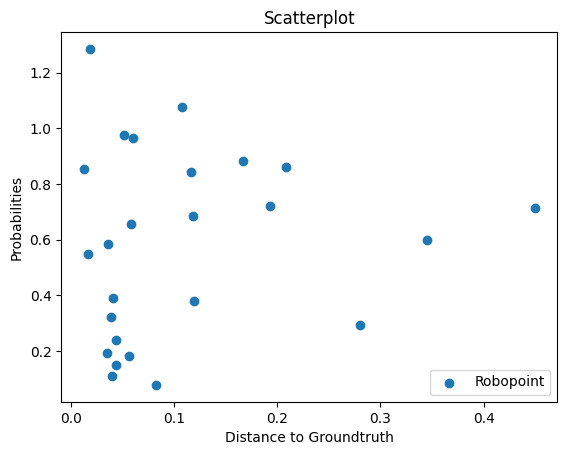

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


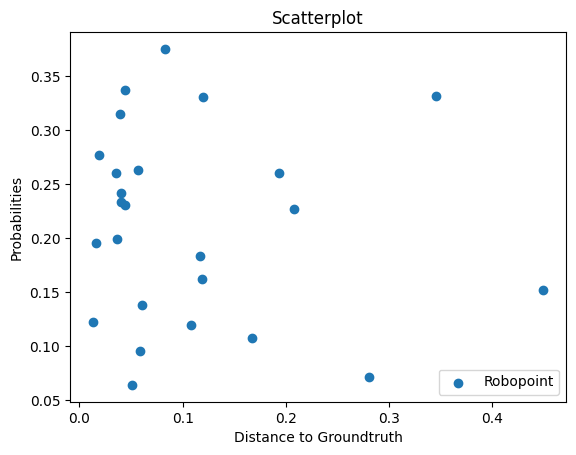

In [6]:
import itertools

data_filename = 'results/molmo-temp08-5prompts-6runs-certain-cluster.npz'
plot_filename = 'results/molmo-temp08-5prompts-6runs-certain-cluster.eps'

loaded = np.load(data_filename)
distances_robopoint = loaded['distances']
spreads_robopoint = loaded['spreads']
probs_robopoint = loaded['probs']

plot_scatter_report(["Robopoint"], [distances_robopoint], [spreads_robopoint], plot_filename)
plot_scatter_report(["Robopoint"], [distances_robopoint], [probs_robopoint], plot_filename)

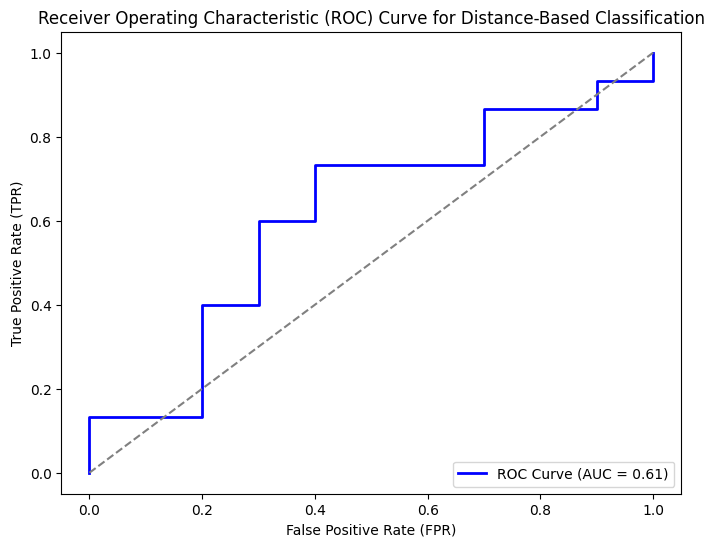

Best Threshold: 0.19569620539744695 with tpr = 0.7333333333333333 and fpr = 0.4


In [8]:
scores = probs_robopoint
fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances_robopoint, 0.1, scores)
plot_roc_curve(fpr, tpr, roc_auc)

j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
print(f"Best Threshold: { thresholds[best_idx] } with tpr = { tpr[best_idx] } and fpr = { fpr[best_idx] }")